# Kepler dataset 

* Goal: Predict koi_disposition using all vaiables except koi_pdispositon   
* Secondary goal: Using 'CANDIDATES' from koi_pdisposition predict which rows are most likely to become 'CONFIRMED' in koi_disposition 

In [211]:
#
# Imports 
#
import pandas as pd
import numpy as np
from sklearn import preprocessing
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import regularizers
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

%matplotlib notebook

In [212]:
def fill_median(data):
    for column in data.columns:
        print("Current columns: ", column, data[column].dtypes)
        tmp = data[column].dtypes
        
        if tmp == 'int64' or tmp == 'float64':
            median = data[column].median()
            data[column] = data[column].fillna(median)
            
    return data

def create_3d_plot(data, target, figsize, class_list):
    plt.clf()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    for c, dispo, a in class_list:
        tmp_df = data[data[target] == dispo]
        xs = tmp_df['X']
        ys = tmp_df['Y']
        zs = tmp_df['Z']
        ax.scatter(xs, ys, zs, s=30, alpha=a, edgecolors='w', c=c)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # ax.view_init(30, 90)
    # plt.show()
    
    # rotate the axes and update
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

    
def outlier_detector(data, contamination=0.01):
    #print("----------------- ISOLATION  FOREST -----------------------")
    inliers = np.ones((len(data),), dtype=int)
    inliers_df = pd.DataFrame(inliers)
    
    for column in data.columns[2:]:
        
        clf = IsolationForest(random_state=0, n_estimators=300,verbose=0, n_jobs=16, contamination=contamination, max_features=1)
        clf.fit(data[column].values.reshape(-1,1))
        predictions = clf.predict(data[column].values.reshape(-1,1))
        
        predictions_df = pd.DataFrame(predictions, columns=['pred'])
        #print('----', column, '----', '\n', predictions_df['pred'].value_counts())
        inliers_df[predictions_df['pred'] == -1] = -1
        
    return inliers_df

In [151]:
#
# Import dataset 
#
data = pd.read_csv('cumulative.csv')

In [152]:
#
# Data cleaning 
#

drop_columns = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_score', 'koi_teq_err1', 'koi_teq_err2', 'koi_tce_delivname']
data[drop_columns].head()

,rowid,kepid,kepoi_name,kepler_name,koi_score,koi_teq_err1,koi_teq_err2,koi_tce_delivname
0,1,10797460,K00752.01,Kepler-227 b,1.000,NaN,NaN,q1_q17_dr25_tce
1,2,10797460,K00752.02,Kepler-227 c,0.969,NaN,NaN,q1_q17_dr25_tce
2,3,10811496,K00753.01,NaN,0.000,NaN,NaN,q1_q17_dr25_tce
3,4,10848459,K00754.01,NaN,0.000,NaN,NaN,q1_q17_dr25_tce
4,5,10854555,K00755.01,Kepler-664 b,1.000,NaN,NaN,q1_q17_dr25_tce


`rowid` - The data in this column is nothing more than an index.   
`kepid` - Id for solar system.   
`kepoi_name` - Name for solar system and planet number.  
`kepler_name` - Name for exoplanet. NaN represents none expoplanets.   
`koi_score` - NASA prediction score for candidate.   
`koi_teq_err1` - Entire column is NaN.  
`koi_teq_err2` - Entire column is NaN.  

In [153]:
data = data.drop(drop_columns, axis = 1)

In [154]:
rows_nan = data.isna().sum(axis=1)
rows_nan.value_counts()

0     8744
1      263
29     230
6       95
30      91
10      89
26      42
7        8
16       2
dtype: int64

We got 40 features, to reduce noise in the datset we remove samples that are missing more than 10 % of their feature values, which is 4 or more missing feature values. As we can see in the data above there are several samples that are missing a lot of data. If we were to just insert the median in to these missing values we would introduce noise or skew the data.  

In [155]:
rows_nan = rows_nan[rows_nan >= 4]
rows_nan = rows_nan.reset_index()
data = data.drop(index = rows_nan["index"].to_numpy(), axis = 0)

In [156]:
rows_nan = data.isna().sum(axis=1)
rows_nan.value_counts()

0    8744
1     263
dtype: int64

In [157]:
data['koi_disposition'].value_counts()

FALSE POSITIVE    4552
CONFIRMED         2292
CANDIDATE         2163
Name: koi_disposition, dtype: int64

We are more interesting to keep 'CANDIDATES' and 'CONFIRMED' in the columnn `koi_disposition` because they add more value in the modeling process compared to 'FALSE POSITIVE', because it's 50% of the dataset while 'CONFIRMED' is about 25%. 



In [158]:
# Seperate False Positives from Candidates and Confirmed
# This is to run seperate Data Cleaning processes on the sets
data_fp = data[data['koi_disposition'] == 'FALSE POSITIVE']
data_cc = data[data['koi_disposition'] != 'FALSE POSITIVE']
data_fp = data_fp.dropna(axis = 0) # Drop every row that contains atleast one NaN
data_cc = fill_median(data_cc) # Fill each NaN with the median of the column

# Merge the two datasets back together after cleaning
data = pd.concat([data_fp, data_cc], axis = 0)

Current columns:  koi_disposition object
Current columns:  koi_pdisposition object
Current columns:  koi_fpflag_nt int64
Current columns:  koi_fpflag_ss int64
Current columns:  koi_fpflag_co int64
Current columns:  koi_fpflag_ec int64
Current columns:  koi_period float64
Current columns:  koi_period_err1 float64
Current columns:  koi_period_err2 float64
Current columns:  koi_time0bk float64
Current columns:  koi_time0bk_err1 float64
Current columns:  koi_time0bk_err2 float64
Current columns:  koi_impact float64
Current columns:  koi_impact_err1 float64
Current columns:  koi_impact_err2 float64
Current columns:  koi_duration float64
Current columns:  koi_duration_err1 float64
Current columns:  koi_duration_err2 float64
Current columns:  koi_depth float64
Current columns:  koi_depth_err1 float64
Current columns:  koi_depth_err2 float64
Current columns:  koi_prad float64
Current columns:  koi_prad_err1 float64
Current columns:  koi_prad_err2 float64
Current columns:  koi_teq float64
Curre

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [159]:
#
# Data exploration 
#

Investigate the state changes from `koi_pdisposition` to `koi_disposition`. 

In [160]:
classes = data['koi_disposition'].unique()
array = np.empty((2,3), dtype=np.int64)
for i, c in enumerate(classes, start=0):
    mask = (data['koi_disposition'] == c) & (data['koi_pdisposition'] == 'FALSE POSITIVE')
    l = len(data['koi_disposition'][mask])
    array[0, i] = l
    
    mask = (data['koi_disposition'] == c) & (data['koi_pdisposition'] == 'CANDIDATE')
    l = len(data['koi_disposition'][mask])
    array[1, i] = l
    
df = pd.DataFrame(array, columns=classes, index=['FALSE POSITIVE', 'CANDIDATE'])
df

,FALSE POSITIVE,CONFIRMED,CANDIDATE
FALSE POSITIVE,4358,44,0
CANDIDATE,0,2248,2163


We notice that a 44 cases went from FALSE POSITIVE to CONFIRMED. We extract those special cases to be able to separate them later in visualization.  

**ToDo** Outlier removal

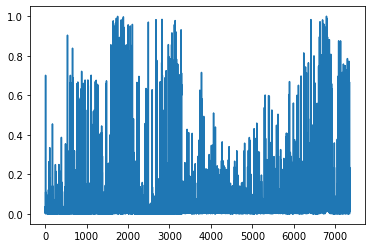

In [202]:
data_norm['koi_period'].plot()

Looking at the values in column `koi_period` we can directly identify that there exists outliers that we need to consider. Thus we remove outliers per feature using the Isolation Forest method. 

In [163]:
inliers = outlier_detector(data[data.columns[2:]], contamination=0.01)
inliers[0].value_counts()

 1    7353
-1    1460
Name: 0, dtype: int64

We find ~1400 

In [165]:
data.reset_index(drop=True, inplace=True)
data.drop(data[inliers[0] == -1].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [169]:
data['koi_disposition'].value_counts()

FALSE POSITIVE    3303
CONFIRMED         2180
CANDIDATE         1870
Name: koi_disposition, dtype: int64

We notice that its mostly FALSE POSITIVE and some CANDIDATES that got removed, e.g. had outliers. 

We standardize data then normalize, making it easier to process for visualization and modeling.

In [172]:
#
# Data preprocessing 
#
standardization = preprocessing.StandardScaler()
standardized_data = standardization.fit_transform(data[data.columns[2:]]) 

normalization = preprocessing.MinMaxScaler()
normalized_data = normalization.fit_transform(standardized_data)

columns = data.columns[2:] 
data_split_x = pd.DataFrame(data = normalized_data, columns = columns)
data_split_y = data[data.columns[0:2]]

data_norm = pd.concat([data_split_y, data_split_x], axis=1)
data_norm.head()

,koi_disposition,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.035576,0.000466,0.999534,0.170095,...,0.529412,0.788609,0.054208,0.526611,0.056938,0.100829,0.980759,0.797435,0.769203,0.784639
1,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.002609,0.000008,0.999992,0.153057,...,0.534759,0.796254,0.067047,0.549020,0.050443,0.086096,0.983826,0.218897,0.779917,0.807081
2,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,1.0,0.0,0.012819,0.000664,0.999336,0.036072,...,0.668449,0.575306,0.251070,0.745098,0.148882,0.141805,0.867819,0.891227,0.344955,0.397686
3,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.034677,0.000645,0.999355,0.159748,...,0.596257,0.806575,0.094151,0.885154,0.041080,0.026703,0.984384,0.406709,0.733830,0.791748
4,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.034345,0.000034,0.999966,0.196845,...,0.465241,0.770260,0.065621,0.436975,0.063602,0.135359,0.975739,0.737400,0.737733,0.771397


**ToDo** Check correlation between features in dataset

PCA visualization

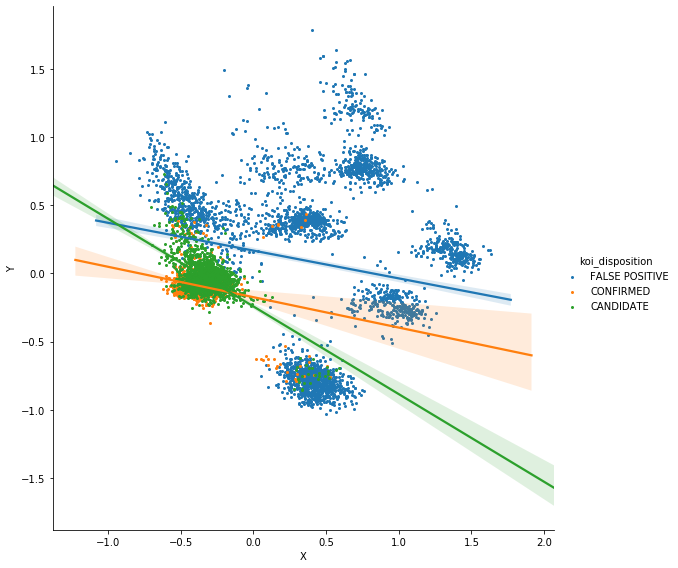

In [197]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components = 2)
data_pca = pd.DataFrame(pca.fit_transform(data_split_x), columns = ['X', 'Y'])
data_pca = pd.concat([data_split_y, data_pca], axis = 1)
sns.lmplot(x='X', y='Y', hue = 'koi_disposition', data=data_pca, scatter_kws={'alpha':1, 's':4}, height=8)

We notice a cluster for CONFIRMED and CANDIDATE, and several clusters for FALSE POSITIVES. We have several samples of CONFIRMED and CANDIDATES scattered outside the green cluster even though we cleaned our dataset from outliers. 

An interesting subproblem would be to investigate what is the difference between the FALSE POSITIVE clusters, maybe these could be different types of stellar objects. 

\*The orange CONFIRMED markers are rendered behind the green CANCDIDATE markers. 

<IPython.core.display.Javascript object>


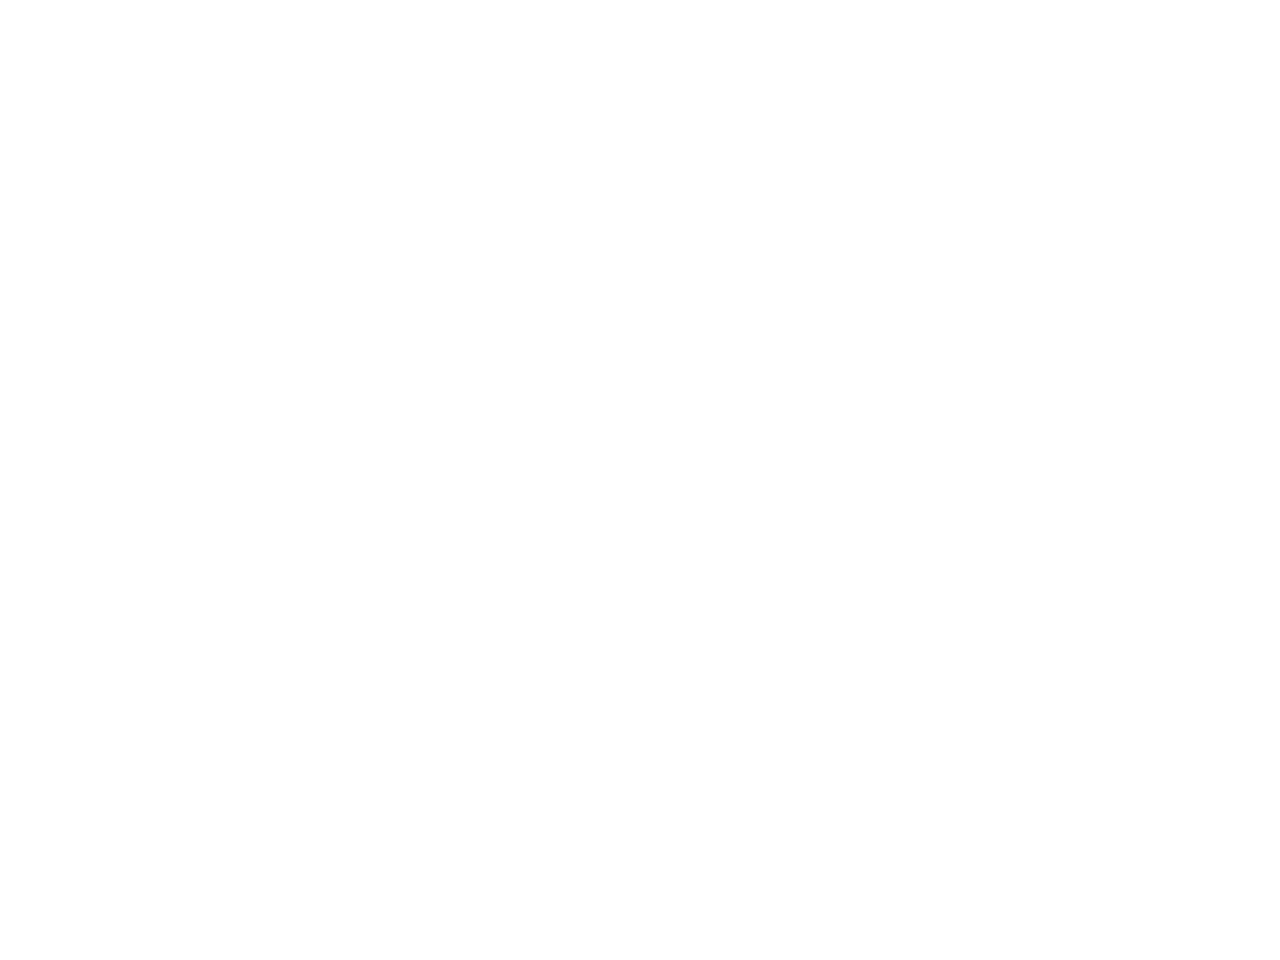

<IPython.core.display.Javascript object>


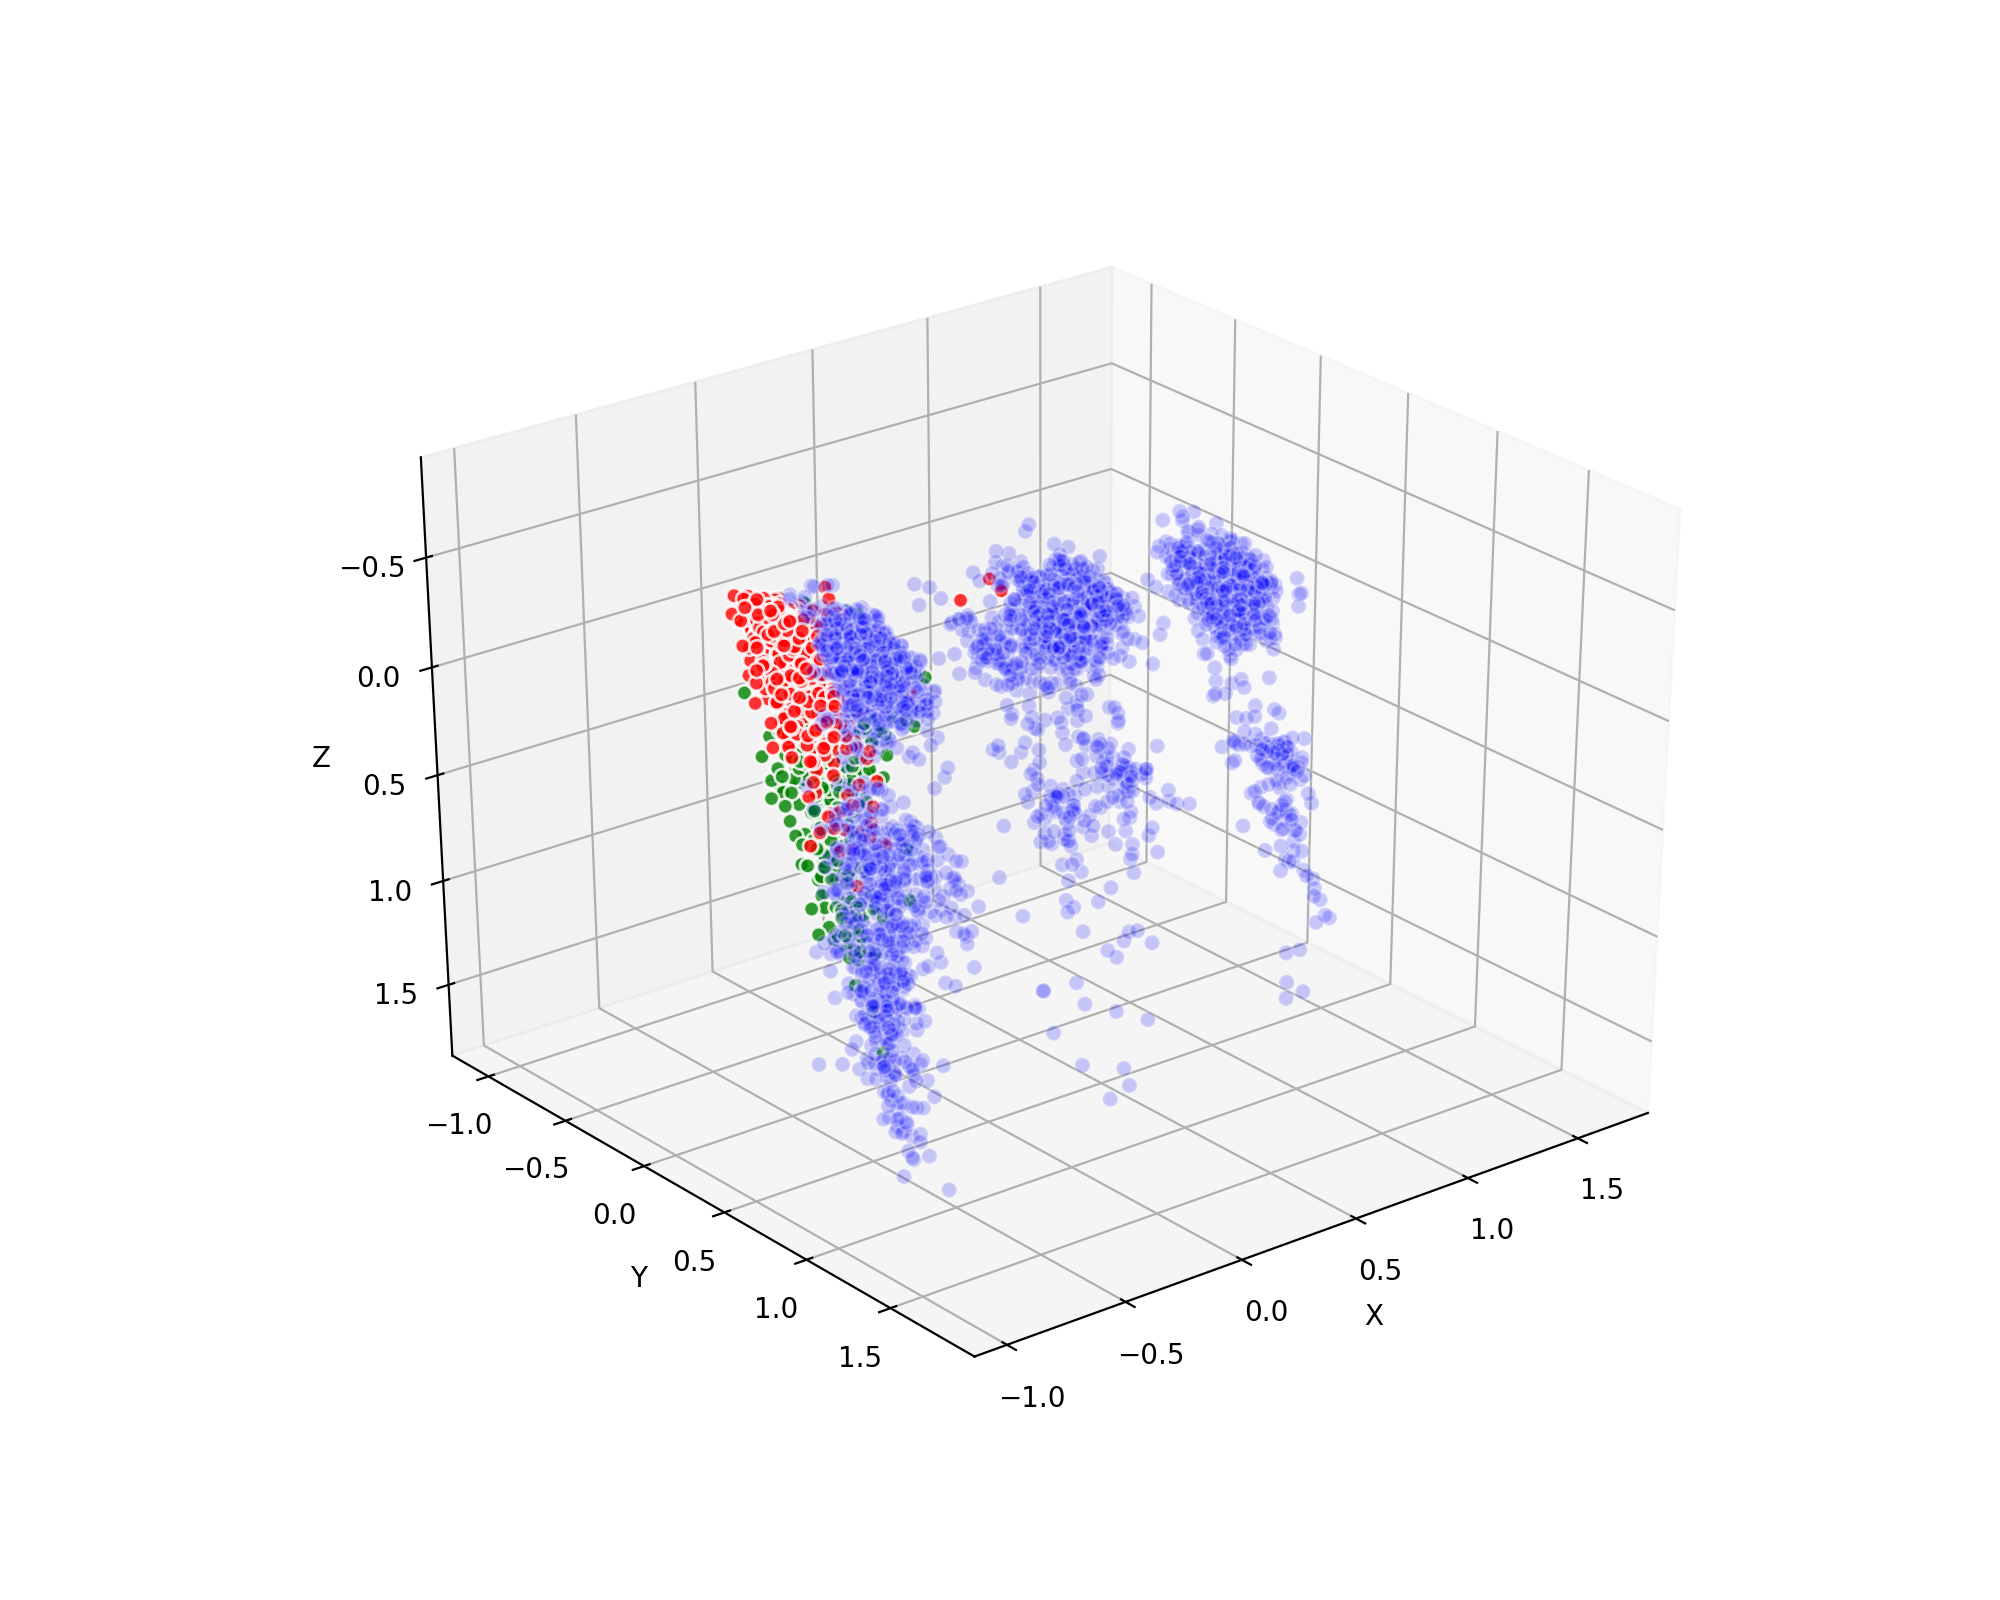

In [214]:
pca = PCA(n_components = 3)
data_pca_3 = pd.DataFrame(pca.fit_transform(data_split_x), columns = ['X', 'Y', 'Z'])
data_pca_3 = pd.concat([data_split_y, data_pca_3], axis = 1)

classes = [('b', 'FALSE POSITIVE', 0.2), ('r', 'CONFIRMED', 0.8), ('g', 'CANDIDATE', 0.8), ('purple', 'FP_CONFIRMED', 1)]
create_3d_plot(data_pca_3,'koi_disposition',(10,8),classes)

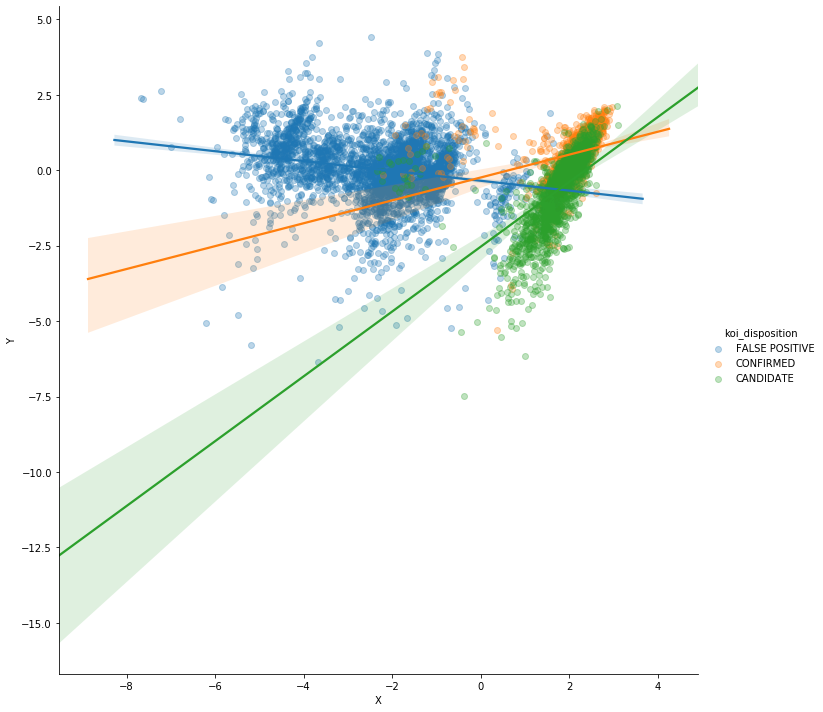

In [186]:
lda = LinearDiscriminantAnalysis(n_components = 2)
data_split_lda = data_split_y.replace({'FALSE POSITIVE': 0, 'CANDIDATE': 1, 'CONFIRMED': 2, 'FP_CONFIRMED': 3})

data_lda = pd.DataFrame(lda.fit_transform(data_split_x, data_split_lda['koi_disposition']), columns = ['X', 'Y'])
data_lda = pd.concat([data_split_y, data_lda], axis = 1)

sns.lmplot(x='X', y='Y', hue = 'koi_disposition', data=data_lda, scatter_kws={'alpha':0.3}, height=10)

In [171]:
#
# Modeling
#
data_norm

############
# Random forest on dataset: data, data_norm


,koi_disposition,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.035576,0.000466,0.999534,0.170095,...,0.529412,0.788609,0.054208,0.526611,0.056938,0.100829,0.980759,0.797435,0.769203,0.784639
1,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.002609,0.000008,0.999992,0.153057,...,0.534759,0.796254,0.067047,0.549020,0.050443,0.086096,0.983826,0.218897,0.779917,0.807081
2,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,1.0,0.0,0.012819,0.000664,0.999336,0.036072,...,0.668449,0.575306,0.251070,0.745098,0.148882,0.141805,0.867819,0.891227,0.344955,0.397686
3,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.034677,0.000645,0.999355,0.159748,...,0.596257,0.806575,0.094151,0.885154,0.041080,0.026703,0.984384,0.406709,0.733830,0.791748
4,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.034345,0.000034,0.999966,0.196845,...,0.465241,0.770260,0.065621,0.436975,0.063602,0.135359,0.975739,0.737400,0.737733,0.771397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7348,CANDIDATE,CANDIDATE,0.0,0.0,0.0,0.0,0.153379,0.103871,0.896129,0.184212,...,0.887701,0.607416,0.009986,0.988796,0.102320,0.016575,0.996654,0.262336,0.410497,0.228046
7349,CANDIDATE,CANDIDATE,0.0,0.0,0.0,0.0,0.008054,0.004589,0.995411,0.034649,...,0.462567,0.754969,0.071327,0.392157,0.069000,0.145028,0.971835,0.403940,0.511856,0.573599
7350,CANDIDATE,CANDIDATE,0.0,0.0,0.0,0.0,0.235850,0.094598,0.905402,0.300498,...,0.510695,0.782875,0.042796,0.481793,0.059890,0.109116,0.979085,0.422663,0.512906,0.862002
7351,CANDIDATE,CANDIDATE,0.0,0.0,0.0,0.0,0.015557,0.000281,0.999719,0.052150,...,0.516043,0.590979,0.610556,0.498599,0.111430,0.189687,0.824038,0.451646,0.918481,0.525788


In [58]:
#
# Evaluation 
#